---
### Universidad de Costa Rica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas
---

- Estudiante: **Luis Javier Herrera Barrantes**
- Carné: **B93840**
- Estudiantes: **Martin Sander Hangen**
- Carné: **B97333**


# *Proyecto 5 Procesos M/M/s*

### Parte 1 (40%)

>#### Hacer la determinación teórica del número  𝑠  de servidores necesarios para cumplir el requisito.

In [35]:
import math

# phi_0
def phi_0(s, p):
    suma = 0 
    # Se realiza primero una sumatoria
    for k in range(0, s):  # Rango de 0 a s-1
        suma+= ((s*p)**k)/(math.factorial(k))

    suma+= ((s*p)**s)/((math.factorial(s))*(1-p)) 
    suma = suma**-1
    return suma 


In [36]:
#Funciones para calcular porbabilidad phi_i

def phi_i_min(i, s, p, phi_0):  # phi_i para i < s
    formula = (((s*p)**i)/(math.factorial(i)))*phi_0
    return formula

def phi_i_max(i, s, p, phi_0):  # philetra _i para i > s
    formula = (((s**s)*(p**i))/(math.factorial(s)))*phi_0
    return formula

In [37]:
# Cálculo de probabilidad

# Cantidad de servidores
s = 17
#Tasa de llegada lambda
lmbda = 4
#Tasa de salida v
v = 0.25
p = lmbda/(v*s)
prob_menos_50 = 0
n = 50+s
for i in range(n+1):
    # Calcular probabilidad de que hayan 50 personas en fila
    if (i < s):
        prob_menos_50+= phi_i_min(i, s, p, phi_0(s,p))
    if (i >= s):
        prob_menos_50+= phi_i_max(i, s, p, phi_0(s,p))

# Probabilidad de que hayan 50 o más clientes en fila
prob_mas_50 = (1-prob_menos_50)*100
print("La probabilidad de tener una cantidad mayor a 50 personas en fila con %.d servidores es de %.2f %%" %(s,prob_mas_50))

La probabilidad de tener una cantidad mayor a 50 personas en fila con 17 servidores es de 3.35 %


Con los cálculos anteriormente realizados se puede afirmar que con una cantidad de 17 servidores la probobabilidad de tener una cantidad mayor a 50 personas es menor al 5% por lo cual se procede a realizar la siguiente parte con este dato. 

### Parte 2 (60%)

>#### Modificar el código provisto para simular y corroborar el resultado anterior y crear al menos dos gráficas que muestren esta simulación.

In [45]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def simu(N, lam, nu, s):


    # Distribución de los tiempos de llegada entre cada cliente
    X = stats.expon(scale = 1/lam)

    # Distribución de los tiempos de servicio a cada cliente
    Y = stats.expon(scale = 1/(nu))

    # Intervalos entre llegadas (segundos desde último cliente)
    t_intervalos = np.ceil(X.rvs(N)).astype('int')

    # Tiempos de las llegadas (segundos desde el inicio)
    t_llegadas = [t_intervalos[0]]
    for i in range(1, len(t_intervalos)):
        siguiente = t_llegadas[i-1] + t_intervalos[i]
        t_llegadas.append(siguiente)

    # Tiempos de servicio (segundos desde inicio de servicio)
    t_servicio = np.ceil(Y.rvs(N)).astype('int')
    

    # Inicialización del tiempo de inicio y fin de atención
    inicio = t_llegadas[0]          # primera llegada
    fin = inicio + t_servicio[0]    # primera salida
    
    #Vector para guardar los tiempos del fin de servicio 
    servidores = np.zeros(s)
    
    #Primer cliente
    servidores [0] = fin 
    
    # Tiempos en que recibe atención cada i-ésimo cliente (!= que llega)
    t_atencion = [inicio]
    
    
    for i in range(1, N):
        
        desocupados = np.where(servidores <= t_llegadas[i]) # recorre los servidores que están desocupados 
        
        if  len(desocupados[0]) == 0:
            inicio = np.min(servidores) + 1
            fin = inicio + t_servicio[i]
            
        else:
            inicio = t_llegadas[i]
            fin = inicio + t_servicio[i]
        
        j = servidores.tolist().index(np.min(servidores))
        servidores[j] = fin 
        t_atencion.append(inicio.astype(int))

    # Inicialización del vector temporal para registrar eventos
    t = np.zeros(t_atencion[-1] + max(t_servicio) + 1)

    # Asignación de eventos de llegada (+1) y salida (-1) de clientes
    for c in range(N):
        i = t_llegadas[c]
        t[i] += 1
        j = t_atencion[c] + t_servicio[c]
        t[j] -= 1

    # Umbral de P o más personas en sistema (hay P - 1 en fila)
    P = 50+s+1

    # Instantes (segundos) de tiempo con P o más solicitudes en sistema
    exceso = 0

    # Proceso aleatorio (estados n = {0, 1, 2...})
    Xt = np.zeros(t.shape)

    # Inicialización de estado n
    n = 0

    # Recorrido del vector temporal y conteo de clientes (estado n)
    for i, c in enumerate(t):
        n += c # sumar (+1) o restar (-1) al estado
        Xt[i] = n
        if Xt[i] >= P: 
            exceso += 1

    # Fracción de tiempo con P o más solicitudes en sistema
    fraccion = exceso / len(t)

    # Resultados
    print('Parámetro lambda =', str(lam*60))
    print('Parámetro nu =', str(nu*60))
    print('Cantidad de servidores =', str(s))
    print('Tiempo con más de {} solicitudes en fila:'.format(P-1))
    print('\t {:0.2f}%'.format(100*fraccion))
    
    if fraccion <= 0.05:
        print('\t Sí cumple con la especificación.')
    else:
        print('\t No cumple con la especificación.') 
    print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))

    # Gráfica de X(t) (estados del sistema)
    plt.figure()
    plt.plot(Xt)
    plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
    plt.legend(('$X(t) = n$', '$L_q = $' + str(P-1)))
    plt.ylabel('Clientes en el sistema, $n$')
    plt.xlabel('Tiempo, $t$ / segundos')
    plt.xlim((0, 15000))
    plt.show()

Parámetro lambda = 4.0
Parámetro nu = 0.25
Cantidad de servidores = 16
Tiempo con más de 66 solicitudes en fila:
	 36.54%
	 No cumple con la especificación.
Simulación es equivalente a 17.96 horas.


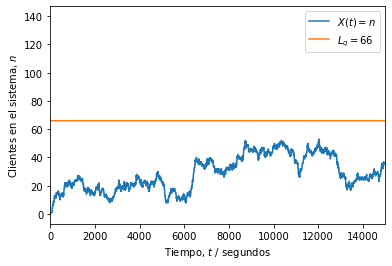

In [46]:
# Simulación con s=16
simu(4000, (4/60), (0.25/60), 16)

Parámetro lambda = 4.0
Parámetro nu = 0.25
Cantidad de servidores = 17
Tiempo con más de 67 solicitudes en fila:
	 0.00%
	 Sí cumple con la especificación.
Simulación es equivalente a 17.81 horas.


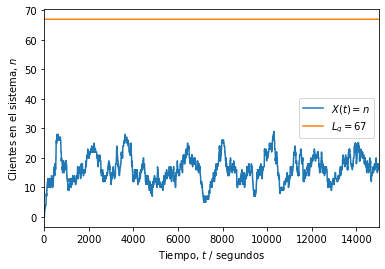

In [48]:
# Simulación con s=17
simu(4000, (4/60), (0.25/60), 17)